## Setup

In [1]:
# importing libraries
import requests
import time
import json
from datetime import datetime
import re
import warnings

import numpy as np
import pandas as pd
from textblob import TextBlob

warnings.filterwarnings("ignore")

# defining anomaly target games (controversial games)
ANOMALY_TARGETS = {
    553850: (
        "Helldivers 2",
        ["2024-05-03", "2024-05-04", "2024-05-05", "2024-05-06", "2024-05-07"],
        ["bombing"],
    ),
    1245620: (
        "ELDEN RING",
        ["2022-02-25", "2022-02-26", "2022-02-27", "2022-02-28", "2022-03-01"],
        ["bombing"],
    ),
    1091500: (
        "Cyberpunk 2077",
        ["2020-12-10", "2020-12-11", "2020-12-12", "2020-12-13", "2020-12-14"],
        ["bombing"],
    ),
    1006510: (
        "Devotion",
        ["2019-02-21", "2019-02-22", "2019-02-23", "2019-02-24", "2019-02-25"],
        ["bombing"],
    ),
    1151340: (
        "Fallout 76",
        ["2018-11-14", "2018-11-15", "2018-11-16", "2018-11-17", "2018-11-18"],
        ["bombing"],
    ),
    535230: (
        "Domina",
        ["2022-03-12", "2022-03-13", "2022-03-14", "2022-03-15"],
        ["bombing"],
    ),
    730: (
        "Counter-Strike 2",
        ["2023-09-27", "2023-09-28", "2023-09-29", "2023-09-30"],
        ["bots", "bombing"],
    ),
    570: (
        "Dota 2",
        ["2023-06-01", "2023-06-02", "2023-06-03", "2023-06-04"],
        ["bots"],
    ),
    1172470: (
        "Apex Legends",
        ["2019-02-04", "2019-02-05", "2019-02-06", "2019-02-07"],
        ["bots", "paid"],
    ),
    252490: (
        "Rust",
        ["2018-12-01", "2018-12-02", "2018-12-03"],
        ["bots"],
    ),
    1623730: (
        "Palworld",
        ["2024-01-19", "2024-01-20", "2024-01-21"],
        ["paid", "bots"],
    ),
    1938090: (
        "Call of Duty: Modern Warfare II",
        ["2022-10-28", "2022-10-29", "2022-10-30", "2022-10-31"],
        ["bombing", "paid"],
    ),
    271590: (
        "Grand Theft Auto V",
        ["2017-06-14", "2017-06-15", "2017-06-16"],
        ["bombing"],
    ),
}

# defining control games (more normal behaviour)
CONTROL_GAMES = {
    413150: ("Stardew Valley", [], ["normal"]),
    1145360: ("Hades", [], ["normal"]),
    292030: ("The Witcher 3: Wild Hunt", [], ["normal"]),
}


## Collector Class

In [3]:
# creating review collector class
class ReviewCollector:
    BASE_URL = "https://store.steampowered.com/appreviews/{}"

    def __init__(self, sleep_between_calls=0.4):
        # creating HTTP session
        self.session = requests.Session()
        self.session.headers.update(
            {"User-Agent": "Mozilla/5.0 (anomaly-dataset-builder)"}
        )
        self.sleep_between_calls = sleep_between_calls

    def _fetch_page(self, app_id, cursor="*", strategy=None, num_per_page=100):
        # defining default strategy dict
        if strategy is None:
            strategy = {}

        # building query params
        params = {
            "json": 1,
            "cursor": cursor,
            "num_per_page": num_per_page,
            "language": "english",
            "filter": strategy.get("filter", "recent"),
            "review_type": strategy.get("review_type", "all"),
            "purchase_type": strategy.get("purchase_type", "all"),
            "day_range": strategy.get("day_range", 0),
            "followup": 0,
        }

        # adding sort parameter if requested
        sort = strategy.get("sort")
        if sort:
            params["sort"] = sort

        # sending request
        try:
            resp = self.session.get(
                self.BASE_URL.format(app_id),
                params=params,
                timeout=15,
            )
            data = resp.json()
        except Exception as e:
            print(f"      ! Error fetching page for app {app_id}: {e}")
            return [], None, False

        # checking success flag
        if data.get("success", 0) != 1:
            return [], None, False

        # extracting reviews and next cursor
        reviews = data.get("reviews", [])
        next_cursor = data.get("cursor")
        return reviews, next_cursor, True

    def collect_for_game(self, app_id, game_name, incident_dates,
                         expected_anomalies, target_count=300):
        # initializing storage
        all_reviews = {}
        total_fetched = 0

        # defining simple broad strategies
        strategies = [
            {"name": "recent_all", "filter": "recent", "review_type": "all"},
            {"name": "recent_negative", "filter": "recent", "review_type": "negative"},
            {"name": "recent_positive", "filter": "recent", "review_type": "positive"},
            {"name": "all_helpful", "filter": "all", "review_type": "all", "sort": "helpfulness"},
        ]

        print(f"  Collecting up to {target_count} reviews...")

        # iterating over strategies
        for strat in strategies:
            if total_fetched >= target_count:
                break

            cursor = "*"

            # iterating over pages within one strategy
            while total_fetched < target_count:
                remaining = target_count - total_fetched
                num_per_page = min(100, remaining)

                # fetching one page
                reviews, cursor, ok = self._fetch_page(
                    app_id, cursor=cursor, strategy=strat, num_per_page=num_per_page
                )

                # breaking if request failed or empty
                if not ok or not reviews:
                    break

                # processing each review
                for r in reviews:
                    rid = r.get("recommendationid")

                    # skipping duplicates across strategies
                    if rid in all_reviews:
                        continue

                    # attaching game metadata
                    r["game_id"] = app_id
                    r["game_name"] = game_name
                    r["expected_anomalies"] = "|".join(expected_anomalies)
                    r["collection_strategy"] = strat["name"]
                    r["collection_time"] = datetime.now().isoformat()

                    # computing anomaly indicators once here
                    r["anomaly_indicators"] = self.detect_anomaly_patterns(r)
                    r["anomaly_score"] = sum(r["anomaly_indicators"].values())

                    # computing incident proximity
                    days, near = self.compute_incident_proximity(r, incident_dates)
                    r["days_from_incident"] = days
                    r["near_incident"] = near

                    # storing review
                    all_reviews[rid] = r
                    total_fetched += 1

                    if total_fetched >= target_count:
                        break

                # breaking if no cursor returned
                if not cursor:
                    break

                # sleeping for rate limiting
                time.sleep(self.sleep_between_calls)

        print(f"  -> Collected {total_fetched} unique reviews for {game_name}")
        return list(all_reviews.values())

    @staticmethod
    def compute_incident_proximity(review, incident_dates):
        # handling missing timestamps or incident dates
        ts = review.get("timestamp_created")
        if not ts or not incident_dates:
            return 999, 0

        # converting timestamp to datetime
        try:
            rdate = datetime.fromtimestamp(ts)
        except Exception:
            return 999, 0

        # computing min distance to incident dates
        diffs = []
        for d in incident_dates:
            try:
                idate = datetime.strptime(d, "%Y-%m-%d")
                diffs.append(abs((rdate - idate).days))
            except Exception:
                continue

        if not diffs:
            return 999, 0

        min_days = min(diffs)
        near = 1 if min_days <= 7 else 0
        return min_days, near

    @staticmethod
    def detect_anomaly_patterns(review):
        # initializing indicator dict
        indicators = {}

        # extracting author info
        author = review.get("author", {}) or {}
        num_reviews = author.get("num_reviews", 0) or 0
        num_games = author.get("num_games_owned", 0) or 0
        playtime_at_review = author.get("playtime_at_review", 0) or 0

        # setting account-based indicators
        indicators["new_account"] = 1 if num_reviews < 5 else 0
        indicators["limited_library"] = 1 if num_games <= 2 else 0
        indicators["minimal_playtime"] = 1 if playtime_at_review < 60 else 0
        indicators["quick_review"] = 1 if playtime_at_review < 120 else 0

        # extracting review text
        text = review.get("review", "") or ""
        lower = text.lower()

        # checking generic phrases
        generic_phrases = [
            "worth every penny",
            "highly recommend",
            "must buy",
            "waste of money",
            "do not buy",
            "worst game",
            "10/10",
            "0/10",
            "masterpiece",
            "garbage",
        ]
        indicators["generic_text"] = 1 if any(p in lower for p in generic_phrases) else 0

        # computing caps ratio
        if len(text) > 0:
            caps_ratio = sum(1 for c in text if c.isupper()) / len(text)
            indicators["caps_abuse"] = 1 if caps_ratio > 0.3 else 0
        else:
            indicators["caps_abuse"] = 0

        # setting suspicious length flag
        indicators["suspicious_length"] = 1 if (len(text) < 20 or len(text) > 8000) else 0

        # computing engagement flags
        votes_up = review.get("votes_up", 0) or 0
        votes_funny = review.get("votes_funny", 0) or 0
        indicators["no_engagement"] = 1 if (votes_up == 0 and votes_funny == 0) else 0

        # checking purchase info
        received_for_free = review.get("received_for_free", False)
        steam_purchase = review.get("steam_purchase", True)
        indicators["free_copy"] = 1 if received_for_free else 0
        indicators["external_key"] = 1 if not steam_purchase else 0

        return indicators


## Feature Extraction

In [4]:
# defining feature extraction function
def extract_features_from_review(review):
    # creating feature dict
    f = {}

    # storing ids and basic metadata
    f["review_id"] = review.get("recommendationid", "")
    f["game_id"] = review.get("game_id", "")
    f["game_name"] = review.get("game_name", "")
    f["expected_anomalies"] = review.get("expected_anomalies", "")
    f["collection_strategy"] = review.get("collection_strategy", "")

    # extracting text
    text = review.get("review", "") or ""
    lower = text.lower()
    f["review_text"] = text

    # computing basic text statistics
    f["text_length_chars"] = len(text)
    f["text_length_words"] = len(text.split())
    f["text_caps_ratio"] = (
        sum(1 for c in text if c.isupper()) / max(len(text), 1)
    )
    f["text_punct_ratio"] = (
        sum(1 for c in text if c in "!?.,;:") / max(len(text), 1)
    )
    f["text_exclamation_count"] = text.count("!")
    f["text_question_count"] = text.count("?")
    f["text_url_count"] = len(re.findall(r"http[s]?://\S+", text))
    f["text_paragraph_count"] = max(text.count("\n\n") + 1, 1)
    f["text_emoji_like_count"] = len(re.findall(r"[\u263a-\U0001f645]", text))

    # computing sentiment values
    try:
        blob = TextBlob(text[:5000])
        f["sentiment_polarity"] = blob.sentiment.polarity
        f["sentiment_subjectivity"] = blob.sentiment.subjectivity
    except Exception:
        f["sentiment_polarity"] = 0.0
        f["sentiment_subjectivity"] = 0.0

    # extracting vote info
    voted_up = bool(review.get("voted_up", False))
    votes_up = review.get("votes_up", 0) or 0
    votes_funny = review.get("votes_funny", 0) or 0
    comment_count = review.get("comment_count", 0) or 0

    # storing vote features
    f["review_voted_up"] = int(voted_up)
    f["review_votes_up"] = votes_up
    f["review_votes_funny"] = votes_funny
    f["review_comment_count"] = comment_count
    f["review_helpful_ratio"] = votes_up / max(votes_up + votes_funny, 1)
    f["review_engagement_score"] = votes_up + votes_funny + comment_count

    # computing sentiment-vote mismatch
    f["sentiment_vote_mismatch"] = int(
        (f["sentiment_polarity"] > 0.1 and not voted_up)
        or (f["sentiment_polarity"] < -0.1 and voted_up)
    )

    # computing generic phrase counts
    generic_positive = ["masterpiece", "amazing", "perfect", "best game", "10/10", "must buy"]
    generic_negative = ["garbage", "trash", "worst", "terrible", "0/10", "waste"]
    f["text_generic_positive_count"] = sum(p in lower for p in generic_positive)
    f["text_generic_negative_count"] = sum(p in lower for p in generic_negative)

    # extracting author info
    author = review.get("author", {}) or {}
    f["user_num_reviews"] = author.get("num_reviews", 0) or 0
    f["user_num_games"] = author.get("num_games_owned", 0) or 0
    f["user_playtime_at_review_hours"] = (author.get("playtime_at_review", 0) or 0) / 60.0
    f["user_playtime_last_two_weeks_hours"] = (author.get("playtime_last_two_weeks", 0) or 0) / 60.0
    f["user_playtime_forever_hours"] = (author.get("playtime_forever", 0) or 0) / 60.0
    f["user_steamlevel"] = author.get("steamlevel", 0) or 0

    # creating simple account flags
    f["user_is_new"] = int(f["user_num_reviews"] < 5)
    f["user_single_game"] = int(f["user_num_games"] <= 1)
    f["user_low_activity"] = int(
        f["user_num_reviews"] < 10 and f["user_num_games"] < 5
    )

    # computing ratio-based features
    f["user_review_playtime_ratio"] = f["text_length_chars"] / max(
        f["user_playtime_at_review_hours"], 0.1
    )
    f["user_recent_play_ratio"] = f["user_playtime_last_two_weeks_hours"] / max(
        f["user_playtime_forever_hours"], 0.1
    )
    f["user_review_under_2h"] = int(f["user_playtime_at_review_hours"] < 2.0)
    f["user_this_game_focus"] = f["user_playtime_forever_hours"] / max(
        f["user_num_games"], 1
    )
    f["user_reviews_per_game"] = f["user_num_reviews"] / max(
        f["user_num_games"], 1
    )
    f["user_experienced_this_game"] = int(
        f["user_playtime_at_review_hours"] > 20.0
    )

    # extracting timestamps
    ts_created = review.get("timestamp_created", 0) or 0
    ts_updated = review.get("timestamp_updated", 0) or 0
    f["review_timestamp_created"] = ts_created
    f["review_timestamp_updated"] = ts_updated
    f["review_updated"] = int(ts_created != ts_updated)

    # reading purchase info
    steam_purchase = bool(review.get("steam_purchase", False))
    received_for_free = bool(review.get("received_for_free", False))
    early_access = bool(review.get("written_during_early_access", False))

    f["review_steam_purchase"] = int(steam_purchase)
    f["review_received_for_free"] = int(received_for_free)
    f["review_early_access"] = int(early_access)

    # extracting anomaly info
    indicators = review.get("anomaly_indicators", {}) or {}
    f["rule_anomaly_score"] = review.get("anomaly_score", 0) or 0
    f["near_incident"] = review.get("near_incident", 0) or 0
    f["days_from_incident"] = review.get("days_from_incident", 999) or 999

    # mapping indicator flags
    f["anomaly_new_account"] = indicators.get("new_account", 0)
    f["anomaly_minimal_playtime"] = indicators.get("minimal_playtime", 0)
    f["anomaly_quick_review"] = indicators.get("quick_review", 0)
    f["anomaly_generic_text"] = indicators.get("generic_text", 0)
    f["anomaly_caps_abuse"] = indicators.get("caps_abuse", 0)
    f["anomaly_suspicious_length"] = indicators.get("suspicious_length", 0)
    f["anomaly_limited_library"] = indicators.get("limited_library", 0)
    f["anomaly_no_engagement"] = indicators.get("no_engagement", 0)
    f["anomaly_free_copy"] = indicators.get("free_copy", 0)
    f["anomaly_external_key"] = indicators.get("external_key", 0)
    f["anomaly_external_source"] = int(
        indicators.get("external_key", 0) or indicators.get("free_copy", 0)
    )

    return f


## Running collection + building feature table + creating annotation CSV

In [5]:
# creating collector instance
collector = ReviewCollector(sleep_between_calls=0.4)

# initializing list for all reviews
all_reviews = []

print("=" * 80)
print("STARTING REVIEW COLLECTION")
print("=" * 80)

# collecting anomaly games
for app_id, (name, incident_dates, anomaly_types) in ANOMALY_TARGETS.items():
    print(f"\nGame: {name} (ID: {app_id})")
    print(f"  Expected anomalies: {', '.join(anomaly_types)}")
    if incident_dates:
        print(f"  Incident dates: {', '.join(incident_dates)}")

    # collecting reviews for one game
    game_reviews = collector.collect_for_game(
        app_id,
        game_name=name,
        incident_dates=incident_dates,
        expected_anomalies=anomaly_types,
        target_count=300,
    )
    # extending global list
    all_reviews.extend(game_reviews)
    # sleeping between games
    time.sleep(1.0)

print("\n" + "=" * 80)
print("COLLECTING CONTROL GAMES")
print("=" * 80)

# collecting control games
for app_id, (name, incident_dates, anomaly_types) in CONTROL_GAMES.items():
    print(f"\nGame: {name} (ID: {app_id}) [CONTROL]")
    game_reviews = collector.collect_for_game(
        app_id,
        game_name=name,
        incident_dates=incident_dates,
        expected_anomalies=anomaly_types,
        target_count=200,
    )
    all_reviews.extend(game_reviews)
    time.sleep(1.0)

print("\n" + "=" * 80)
print("COLLECTION FINISHED")
print("=" * 80)
print(f"Total raw reviews collected: {len(all_reviews)}")

# saving raw reviews once
with open("reviews_raw.json", "w", encoding="utf-8") as f:
    json.dump(all_reviews, f, ensure_ascii=False, indent=2)
print("✓ saving raw reviews to reviews_raw.json")

# extracting features for all reviews
print("\nExtracting features...")
feature_rows = [extract_features_from_review(r) for r in all_reviews]
features_df = pd.DataFrame(feature_rows)

print(f"  -> {features_df.shape[0]} reviews, {features_df.shape[1]} columns")

# creating simple weak anomaly indicator
features_df["weak_is_anomaly"] = (features_df["rule_anomaly_score"] >= 5).astype(int)

# saving main feature table
features_df.to_csv("reviews_features.csv", index=False)
print("✓ saving feature table to reviews_features.csv")

# preparing annotation subset for manual labelling
print("\nPreparing annotation subset...")

top_n = min(400, len(features_df))
annotation_cols = [
    "review_id",
    "game_name",
    "rule_anomaly_score",
    "near_incident",
    "days_from_incident",
    "user_playtime_at_review_hours",
    "user_num_reviews",
    "user_num_games",
    "review_votes_up",
    "review_votes_funny",
    "review_steam_purchase",
    "review_received_for_free",
    "expected_anomalies",
    "review_text",
]

annotation_df = (
    features_df
    .sort_values("rule_anomaly_score", ascending=False)
    .head(top_n)[annotation_cols]
    .copy()
)

# adding manual labelling columns
annotation_df["anomaly_type"] = ""   # filling with: normal / bot / bombing / paid
annotation_df["confidence"] = ""     # filling with: high / medium / low

# saving annotation template
annotation_df.to_csv("reviews_annotation.csv", index=False)
print(f" saving annotation template to reviews_annotation.csv (top {top_n} reviews)")

# showing quick summary
print("\nDataset summary:")
print(f"  total reviews         : {len(features_df)}")
print(f"  games covered         : {features_df['game_name'].nunique()}")
print(f"  weak anomalies (>=5)  : {features_df['weak_is_anomaly'].sum()}")

STARTING REVIEW COLLECTION

Game: Helldivers 2 (ID: 553850)
  Expected anomalies: bombing
  Incident dates: 2024-05-03, 2024-05-04, 2024-05-05, 2024-05-06, 2024-05-07
  -> Collected 300 unique reviews for Helldivers 2

Game: ELDEN RING (ID: 1245620)
  Expected anomalies: bombing
  Incident dates: 2022-02-25, 2022-02-26, 2022-02-27, 2022-02-28, 2022-03-01
  -> Collected 300 unique reviews for ELDEN RING

Game: Cyberpunk 2077 (ID: 1091500)
  Expected anomalies: bombing
  Incident dates: 2020-12-10, 2020-12-11, 2020-12-12, 2020-12-13, 2020-12-14
  -> Collected 300 unique reviews for Cyberpunk 2077

Game: Devotion (ID: 1006510)
  Expected anomalies: bombing
  Incident dates: 2019-02-21, 2019-02-22, 2019-02-23, 2019-02-24, 2019-02-25
  -> Collected 300 unique reviews for Devotion

Game: Fallout 76 (ID: 1151340)
  Expected anomalies: bombing
  Incident dates: 2018-11-14, 2018-11-15, 2018-11-16, 2018-11-17, 2018-11-18
  -> Collected 300 unique reviews for Fallout 76

Game: Domina (ID: 535230)

## Merging with annotated files

In [6]:
import pandas as pd

# loading main feature table
features_df = pd.read_csv("reviews_features.csv")

# loading manually labelled annotations
annot_df = pd.read_csv("reviews_annotation_labelled.csv")

# keeping only rows with non-empty anomaly_type
annot_df = annot_df[annot_df["anomaly_type"].astype(str).str.strip() != ""].copy()

# keeping only columns needed for merging
label_cols = ["review_id", "anomaly_type", "confidence"]
annot_labels = annot_df[label_cols].copy()

# merging manual labels into main features
features_labelled = features_df.merge(
    annot_labels,
    on="review_id",
    how="left",
    suffixes=("", "_manual")
)

# checking how many reviews got manual labels
n_labeled = features_labelled["anomaly_type"].notna().sum()
print(f"Number of manually labelled reviews: {n_labeled}")

# saving final labelled dataset
features_labelled.to_csv("reviews_features_labelled.csv", index=False)
print(" saving final labelled dataset to reviews_features_labelled.csv")

Number of manually labelled reviews: 253
 saving final labelled dataset to reviews_features_labelled.csv


## Sanity Checks

In [7]:
# checking distribution of manual labels
print("Label counts (including NaN for unlabelled):")
print(features_labelled["anomaly_type"].value_counts(dropna=False))

# checking distribution of confidence levels
print("\nConfidence counts (manual labels only):")
print(features_labelled.loc[features_labelled["anomaly_type"].notna(), "confidence"].value_counts(dropna=False))

Label counts (including NaN for unlabelled):
anomaly_type
NaN        4247
normal      161
bots         50
paid         27
bombing      14
nomal         1
Name: count, dtype: int64

Confidence counts (manual labels only):
confidence
high      106
medium    106
low        41
Name: count, dtype: int64


## Cleaning the dataset

In [8]:
import pandas as pd

# loading labelled dataset
df = pd.read_csv("reviews_features_labelled.csv")

# normalising anomaly_type strings
df["anomaly_type"] = (
    df["anomaly_type"]
    .astype(str)              # converting to string
    .str.strip()              # removing extra spaces
    .str.lower()              # lowercasing values
)

# defining mapping for common typos and variants
label_map = {
    "nomal": "normal",
    "bots": "bot",
    "bot": "bot",
    "bomb": "bombing",
    "bombings": "bombing",
}

# applying mapping
df["anomaly_type"] = df["anomaly_type"].replace(label_map)

# turning "nan" strings back into real NaN
df.loc[df["anomaly_type"] == "nan", "anomaly_type"] = pd.NA

# checking cleaned label counts
print("Cleaned label counts (including NaN):")
print(df["anomaly_type"].value_counts(dropna=False))

Cleaned label counts (including NaN):
anomaly_type
<NA>       4247
normal      162
bot          50
paid         27
bombing      14
Name: count, dtype: int64


In [9]:
# creating binary manual anomaly flag
df["is_anomaly_manual"] = df["anomaly_type"].isin(
    ["bot", "bombing", "paid"]
).astype(int)

print("\nManual anomaly vs normal:")
print(df["is_anomaly_manual"].value_counts(dropna=False))


Manual anomaly vs normal:
is_anomaly_manual
0    4409
1      91
Name: count, dtype: int64


In [10]:
import numpy as np

# marking which rows have any manual label
df["has_manual_label"] = df["anomaly_type"].notna().astype(int)

# creating anomaly flag only for labelled rows
df["is_anomaly_manual"] = np.where(
    df["anomaly_type"].isna(),
    np.nan,  # keeping NaN for unlabelled
    df["anomaly_type"].isin(["bot", "bombing", "paid"]).astype(int)
)

print("Counts in labelled subset only:")
print(df.loc[df["has_manual_label"] == 1, "is_anomaly_manual"].value_counts(dropna=False))

Counts in labelled subset only:
is_anomaly_manual
0.0    162
1.0     91
Name: count, dtype: int64


In [11]:
df.to_csv("reviews_features_labelled_clean.csv", index=False)
print(" saving cleaned dataset to reviews_features_labelled_clean.csv")

 saving cleaned dataset to reviews_features_labelled_clean.csv


## Creating SteamStats Template and fetching review summaries

In [14]:
import pandas as pd

# loading cleaned labelled review dataset
df = pd.read_csv("reviews_features_labelled_clean.csv")

# extracting unique games
games = (
    df[["game_id", "game_name"]]
    .dropna()
    .drop_duplicates()
    .sort_values("game_id")
)

print("Number of unique games:", len(games))
display(games.head())

import requests
import time
import pandas as pd

# defining helper function for reading review summary
def fetch_review_summary(app_id, day_range=None):
    """
    fetching review summary from Steam store 'appreviews' endpoint
    """
    params = {
        "json": 1,
        "language": "english",
        "review_type": "all",
        "purchase_type": "all",
        "num_per_page": 0,      # requesting summary only
        "filter": "all",
    }
    
    # switching to recent mode if day_range is provided
    if day_range is not None:
        params["day_range"] = day_range
        params["filter"] = "recent"
    
    url = f"https://store.steampowered.com/appreviews/{int(app_id)}"
    
    # sending request
    resp = requests.get(url, params=params, timeout=15)
    data = resp.json()
    
    # returning summary dict if successful
    if data.get("success") == 1:
        return data.get("query_summary", {})
    else:
        return {}

# iterating over games and collecting stats
rows = []

for _, row in games.iterrows():
    app_id = int(row["game_id"])
    name = row["game_name"]
    print(f"Fetching stats for {name} (ID: {app_id})...")
    
    # fetching all-time summary
    summary_all = fetch_review_summary(app_id, day_range=None)
    
    # fetching recent summary (last 30 days)
    summary_recent = fetch_review_summary(app_id, day_range=30)
    
    # appending row with Steam-based stats
    rows.append({
        "game_id": app_id,
        "game_name": name,
        "review_score_all": summary_all.get("review_score", 0),
        "review_score_desc_all": summary_all.get("review_score_desc", ""),
        "review_count_all_positive": summary_all.get("total_positive", 0),
        "review_count_all_negative": summary_all.get("total_negative", 0),
        "review_score_recent": summary_recent.get("review_score", 0),
        "review_score_desc_recent": summary_recent.get("review_score_desc", ""),
        "review_count_recent_positive": summary_recent.get("total_positive", 0),
        "review_count_recent_negative": summary_recent.get("total_negative", 0),
    })
    
    # sleeping briefly for being polite to Steam servers
    time.sleep(0.4)

# creating dataframe with game-level stats
steam_store_stats = pd.DataFrame(rows)

# saving to csv
steam_store_stats.to_csv("steam_store_review_stats.csv", index=False)
print("saving Steam store stats to steam_store_review_stats.csv")
display(steam_store_stats.head())

Number of unique games: 16


,game_id,game_name
2100,570,Dota 2
1800,730,Counter-Strike 2
2700,252490,Rust
3600,271590,Grand Theft Auto V
4300,292030,The Witcher 3: Wild Hunt


Fetching stats for Dota 2 (ID: 570)...
Fetching stats for Counter-Strike 2 (ID: 730)...
Fetching stats for Rust (ID: 252490)...
Fetching stats for Grand Theft Auto V (ID: 271590)...
Fetching stats for The Witcher 3: Wild Hunt (ID: 292030)...
Fetching stats for Stardew Valley (ID: 413150)...
Fetching stats for Domina (ID: 535230)...
Fetching stats for Helldivers 2 (ID: 553850)...
Fetching stats for Devotion (ID: 1006510)...
Fetching stats for Cyberpunk 2077 (ID: 1091500)...
Fetching stats for Hades (ID: 1145360)...
Fetching stats for Fallout 76 (ID: 1151340)...
Fetching stats for Apex Legends (ID: 1172470)...
Fetching stats for ELDEN RING (ID: 1245620)...
Fetching stats for Palworld (ID: 1623730)...
Fetching stats for Call of Duty: Modern Warfare II (ID: 1938090)...
saving Steam store stats to steam_store_review_stats.csv


,game_id,game_name,review_score_all,review_score_desc_all,review_count_all_positive,review_count_all_negative,review_score_recent,review_score_desc_recent,review_count_recent_positive,review_count_recent_negative
0,570,Dota 2,8,Very Positive,715110,94375,8,Very Positive,715110,94375
1,730,Counter-Strike 2,8,Very Positive,2102567,327398,8,Very Positive,2102567,327398
2,252490,Rust,8,Very Positive,517049,81257,8,Very Positive,517049,81257
3,271590,Grand Theft Auto V,8,Very Positive,527129,105203,8,Very Positive,527129,105203
4,292030,The Witcher 3: Wild Hunt,9,Overwhelmingly Positive,238322,7811,9,Overwhelmingly Positive,238322,7811


## Merging with main dataset

In [15]:
import pandas as pd

# loading cleaned labelled review-level dataset
df = pd.read_csv("reviews_features_labelled_clean.csv")

# loading Steam store game-level stats
store_stats = pd.read_csv("steam_store_review_stats.csv")

print("Store stats columns:", list(store_stats.columns))

# merging store stats by game_id and game_name
df_enriched = df.merge(
    store_stats,
    on=["game_id", "game_name"],
    how="left"
)

print("Shape before enrichment:", df.shape)
print("Shape after enrichment:", df_enriched.shape)

# saving enriched dataset
df_enriched.to_csv("reviews_features_labelled_enriched.csv", index=False)
print("saving enriched dataset to reviews_features_labelled_enriched.csv")

Store stats columns: ['game_id', 'game_name', 'review_score_all', 'review_score_desc_all', 'review_count_all_positive', 'review_count_all_negative', 'review_score_recent', 'review_score_desc_recent', 'review_count_recent_positive', 'review_count_recent_negative']
Shape before enrichment: (4500, 66)
Shape after enrichment: (4500, 74)
saving enriched dataset to reviews_features_labelled_enriched.csv


## Visual Representation

Total reviews: 4500
Manually labelled reviews: 253
Manual label distribution:
anomaly_type
normal     162
bot         50
paid        27
bombing     14
Name: count, dtype: int64


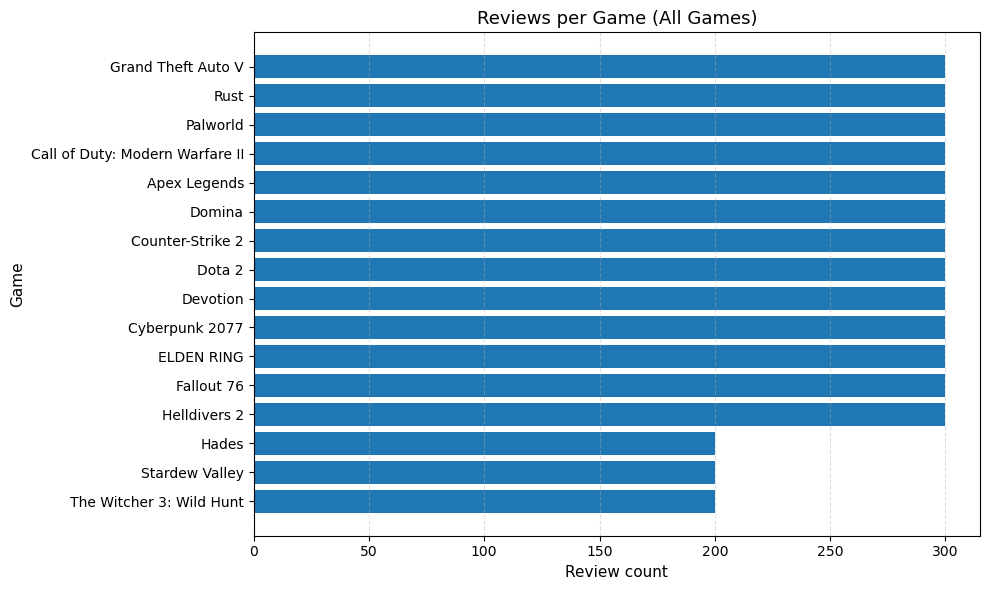

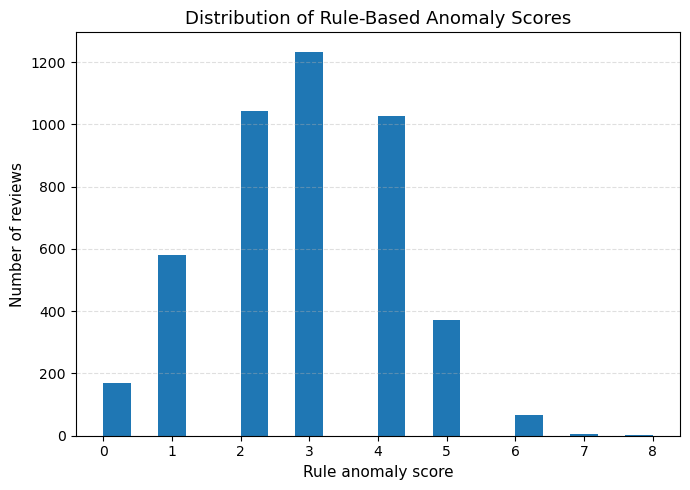

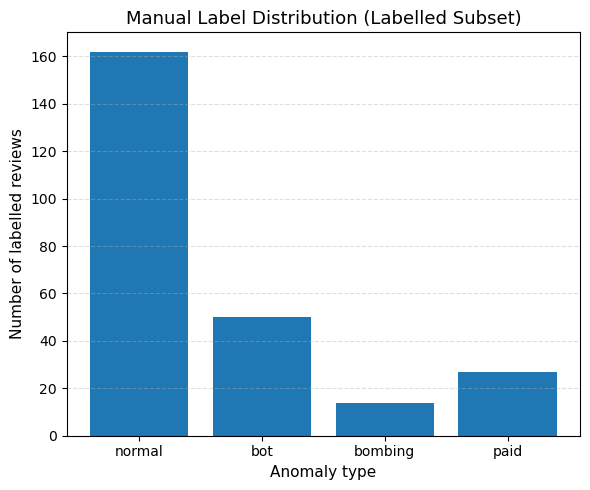

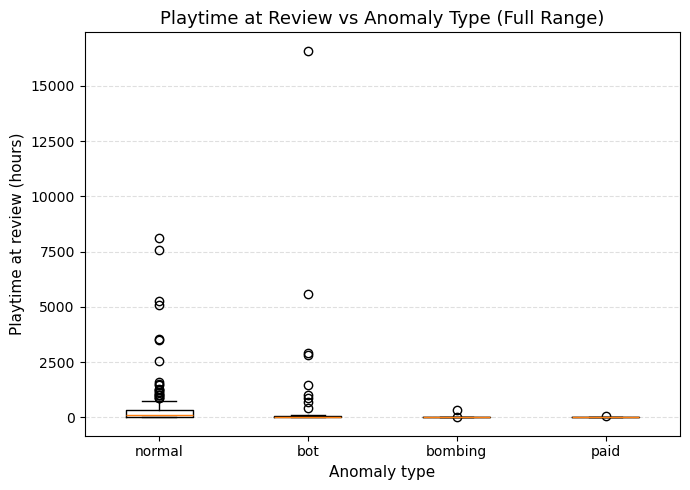

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# loading cleaned labelled dataset
df = pd.read_csv("reviews_features_labelled_clean.csv")

# creating subset with manual labels only
df_labeled = df[df["anomaly_type"].notna()].copy()

print("Total reviews:", len(df))
print("Manually labelled reviews:", len(df_labeled))
print("Manual label distribution:")
print(df_labeled["anomaly_type"].value_counts())

# preparing review counts per game
reviews_per_game = (
    df["game_name"]
    .value_counts()
    .sort_values(ascending=True)
)

# creating figure for reviews per game
plt.figure(figsize=(10, 6))

# plotting horizontal bar chart
plt.barh(reviews_per_game.index, reviews_per_game.values)

# adding labels and title
plt.title("Reviews per Game (All Games)", fontsize=13)
plt.xlabel("Review count", fontsize=11)
plt.ylabel("Game", fontsize=11)

# adding grid for readability
plt.grid(axis="x", linestyle="--", alpha=0.4)

# tightening layout
plt.tight_layout()

# saving figure locally
plt.savefig("fig_reviews_per_game.png", dpi=300, bbox_inches="tight")

# showing figure
plt.show()

# creating figure for rule-based anomaly score distribution
plt.figure(figsize=(7, 5))

# plotting histogram of rule anomaly scores
plt.hist(df["rule_anomaly_score"], bins=20)

# adding labels and title
plt.title("Distribution of Rule-Based Anomaly Scores", fontsize=13)
plt.xlabel("Rule anomaly score", fontsize=11)
plt.ylabel("Number of reviews", fontsize=11)

# adding grid
plt.grid(axis="y", linestyle="--", alpha=0.4)

# tightening layout
plt.tight_layout()

# saving figure locally
plt.savefig("fig_rule_anomaly_score_distribution.png", dpi=300, bbox_inches="tight")

# showing figure
plt.show()

# preparing label counts in a fixed order
label_order = ["normal", "bot", "bombing", "paid"]
label_counts = (
    df_labeled["anomaly_type"]
    .value_counts()
    .reindex(label_order)
    .fillna(0)
)

# creating figure for manual label distribution
plt.figure(figsize=(6, 5))

# plotting bar chart
plt.bar(label_counts.index, label_counts.values)

# adding labels and title
plt.title("Manual Label Distribution (Labelled Subset)", fontsize=13)
plt.xlabel("Anomaly type", fontsize=11)
plt.ylabel("Number of labelled reviews", fontsize=11)

# adding grid
plt.grid(axis="y", linestyle="--", alpha=0.4)

# tightening layout
plt.tight_layout()

# saving figure locally
plt.savefig("fig_manual_label_distribution.png", dpi=300, bbox_inches="tight")

# showing figure
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# loading cleaned labelled dataset
df = pd.read_csv("reviews_features_labelled_clean.csv")

# creating subset with manual labels only
df_labeled = df[df["anomaly_type"].notna()].copy()

# preparing playtime data for boxplot
plot_df = df_labeled[["anomaly_type", "user_playtime_at_review_hours"]].dropna()

# defining label order
label_order = ["normal", "bot", "bombing", "paid"]

# keeping labels that actually exist in the data
box_labels = [t for t in label_order if t in plot_df["anomaly_type"].unique()]

# creating list of playtime series in fixed order
box_data = [
    plot_df.loc[plot_df["anomaly_type"] == t, "user_playtime_at_review_hours"]
    for t in box_labels
]

# creating figure for playtime vs anomaly type (no clipping)
plt.figure(figsize=(7, 5))

if box_data:
    # plotting boxplot with full playtime values
    plt.boxplot(
        box_data,
        labels=box_labels,
        showfliers=True,
    )

    # adding labels and title
    plt.title("Playtime at Review vs Anomaly Type (Full Range)", fontsize=13)
    plt.xlabel("Anomaly type", fontsize=11)
    plt.ylabel("Playtime at review (hours)", fontsize=11)

    # adding grid
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # tightening layout
    plt.tight_layout()

    # saving figure locally
    plt.savefig("fig_playtime_vs_anomaly_type_full.png", dpi=300, bbox_inches="tight")

    # showing figure
    plt.show()
else:
    print("No playtime data available for labelled reviews.")


In [19]:
import pandas as pd
import numpy as np
from pathlib import Path

# setting simple paths
src_csv = Path("reviews_features_labelled_clean.csv")  # file in root
data_dir = Path("data")                                # existing data folder
data_dir.mkdir(exist_ok=True)

# loading cleaned labelled dataset
df = pd.read_csv(src_csv)

anomaly_classes = ["bot", "bombing", "paid"]

# marking which rows are manually labelled
df["has_manual_label"] = df["anomaly_type"].notna().astype(int)

# creating anomaly indicator from manual labels
df["is_anomaly_manual"] = np.where(
    df["anomaly_type"].isna(),
    np.nan,
    df["anomaly_type"].isin(anomaly_classes).astype(int)
)

print("Manual label counts:")
print(df["anomaly_type"].value_counts(dropna=False))

# selecting numeric feature columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
drop_from_features = ["is_anomaly_manual", "has_manual_label"]
feature_cols = [c for c in numeric_cols if c not in drop_from_features]

print("Number of numeric feature columns:", len(feature_cols))

# ---------------------------
# A) labelled-only dataset
# ---------------------------
df_lab = df[df["is_anomaly_manual"].notna()].copy()
df_lab["ground_truth"] = df_lab["is_anomaly_manual"].astype(int)

Xy_labelled = df_lab[feature_cols + ["ground_truth"]].fillna(0)

steam_labelled_path = data_dir / "steam_labelled.csv"
Xy_labelled.to_csv(steam_labelled_path, header=False, index=False)
print("✓ wrote labelled-only dataset to:", steam_labelled_path)
print("  shape:", Xy_labelled.shape)
print("  ground_truth distribution:")
print(Xy_labelled["ground_truth"].value_counts())

# ---------------------------
# B) full dataset (noisy labels)
# ---------------------------
df["ground_truth_full"] = df["is_anomaly_manual"].fillna(0).astype(int)

Xy_full = df[feature_cols + ["ground_truth_full"]].fillna(0)

steam_full_path = data_dir / "steam_full.csv"
Xy_full.to_csv(steam_full_path, header=False, index=False)
print("\n✓ wrote full dataset to:", steam_full_path)
print("  shape:", Xy_full.shape)
print("  ground_truth_full distribution:")
print(Xy_full["ground_truth_full"].value_counts())

Manual label counts:
anomaly_type
NaN        4247
normal      162
bot          50
paid         27
bombing      14
Name: count, dtype: int64
Number of numeric feature columns: 58
✓ wrote labelled-only dataset to: data\steam_labelled.csv
  shape: (253, 59)
  ground_truth distribution:
ground_truth
0    162
1     91
Name: count, dtype: int64

✓ wrote full dataset to: data\steam_full.csv
  shape: (4500, 59)
  ground_truth_full distribution:
ground_truth_full
0    4409
1      91
Name: count, dtype: int64


In [3]:
import pandas as pd
steam_lab = pd.read_csv("data/steam_labelled.csv", header=None)
# checking basic shape
print("Shape:", steam_lab.shape)

# checking dtypes for each column
print("\nDtypes:")
print(steam_lab.dtypes.head())
print("...")
print(steam_lab.dtypes.tail())
import numpy as np

# separating features and labels
X = steam_lab.iloc[:, :-1]
y = steam_lab.iloc[:, -1]

# checking for NaNs in features
print("Any NaNs in X?", X.isna().any().any())

# showing columns that contain NaNs if any
nan_cols = X.columns[X.isna().any()].tolist()
print("Columns with NaNs in X:", nan_cols)

# checking for infinities in features
X_values = X.to_numpy()
print("Any +inf in X?", np.isinf(X_values).any())

# checking min and max for sanity
print("Feature min:", np.nanmin(X_values))
print("Feature max:", np.nanmax(X_values))
# checking unique values in label column
print("Unique values in label column:", sorted(y.unique().tolist()))

# counting occurrences of each label
print("\nLabel counts:")
print(y.value_counts())
# checking if any feature column is non-numeric
non_numeric_cols = X.columns[~X.apply(lambda col: pd.api.types.is_numeric_dtype(col)).values].tolist()
print("Non-numeric feature columns:", non_numeric_cols)
# computing summary stats for first few columns
print("\nSummary stats for first 10 feature columns:")
print(X.iloc[:, :10].describe())

# computing summary stats for last few columns
print("\nSummary stats for last 10 feature columns:")
print(X.iloc[:, -10:].describe())


Shape: (253, 59)

Dtypes:
0      int64
1      int64
2      int64
3      int64
4    float64
dtype: object
...
54    int64
55    int64
56    int64
57    int64
58    int64
dtype: object
Any NaNs in X? False
Columns with NaNs in X: []
Any +inf in X? False
Feature min: -1.0
Feature max: 1762220949.0
Unique values in label column: [0, 1]

Label counts:
58
0    162
1     91
Name: count, dtype: int64
Non-numeric feature columns: []

Summary stats for first 10 feature columns:
                  0             1           2           3           4  \
count  2.530000e+02  2.530000e+02  253.000000  253.000000  253.000000   
mean   2.042619e+08  9.120977e+05   26.786561    5.154150    0.233912   
std    2.246807e+07  7.706516e+05   70.537406   12.806092    0.371095   
min    4.918726e+07  5.700000e+02    1.000000    1.000000    0.000000   
25%    2.080437e+08  2.524900e+05    4.000000    1.000000    0.000000   
50%    2.081567e+08  1.151340e+06    9.000000    2.000000    0.000000   
75%    2.082584e

In [1]:
import pandas as pd
import numpy as np

# load the labelled dataset you already saved
steam_lab = pd.read_csv("data/steam_labelled.csv", header=None)

# split features and labels
X = steam_lab.iloc[:, :-1].copy()
y = steam_lab.iloc[:, -1].copy()

# 1) drop ID-like and constant columns
# we know 0 = review_id, 1 = app_id, and 8, 27, 57 are constant
cols_to_drop = [0, 1, 8, 27, 57]
X = X.drop(columns=cols_to_drop)

print("New feature shape after dropping:", X.shape)

# 2) standardize (z-score) each feature: (x - mean) / std
means = X.mean()
stds = X.std().replace(0, 1)  # avoid div by zero
X_scaled = (X - means) / stds

print("Scaled feature min/max:", X_scaled.to_numpy().min(), X_scaled.to_numpy().max())

# 3) put label back as last column
steam_lab_opt = pd.concat([X_scaled, y], axis=1)

# 4) save as a new CSV for OptIForest
steam_lab_opt.to_csv("data/steam_labelled_opt.csv", header=False, index=False)

print("Wrote: data/steam_labelled_opt.csv, shape:", steam_lab_opt.shape)

New feature shape after dropping: (253, 53)
Scaled feature min/max: -7.108297869648215 15.843104259240663
Wrote: data/steam_labelled_opt.csv, shape: (253, 54)


In [1]:
import pandas as pd
import numpy as np

# loading full dataset
steam_full = pd.read_csv("data/steam_full.csv", header=None)
print("steam_full shape:", steam_full.shape)

# split features and labels
X_full = steam_full.iloc[:, :-1].copy()
y_full = steam_full.iloc[:, -1].copy()

# same columns to drop as for the labelled set:
# 0 = review_id, 1 = app_id, 8/27/57 = constant
cols_to_drop = [0, 1, 8, 27, 57]
X_full = X_full.drop(columns=cols_to_drop)
print("Feature shape after dropping:", X_full.shape)

# standardizing features (z-score)
means_full = X_full.mean()
stds_full = X_full.std().replace(0, 1)  # avoid divide-by-zero
X_full_scaled = (X_full - means_full) / stds_full

print("Scaled feature min/max:",
      X_full_scaled.to_numpy().min(),
      X_full_scaled.to_numpy().max())

# reconstruct full dataset with label as last column
steam_full_opt = pd.concat([X_full_scaled, y_full], axis=1)

# saving to CSV for OptIForest
steam_full_opt.to_csv("data/steam_full_opt.csv", header=False, index=False)
print("Wrote: data/steam_full_opt.csv, shape:", steam_full_opt.shape)

# quick check of label distribution
print("\nLabel distribution in full_opt (last column):")
print(steam_full_opt.iloc[:, -1].value_counts())

steam_full shape: (4500, 59)
Feature shape after dropping: (4500, 53)
Scaled feature min/max: -3.5170440792801063 50.95773757953259
Wrote: data/steam_full_opt.csv, shape: (4500, 54)

Label distribution in full_opt (last column):
58
0    4409
1      91
Name: count, dtype: int64
